In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import dlib

In [2]:
detector= dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("E:/eye_blink_detection/shape_predictor_68_face_landmarks.dat")

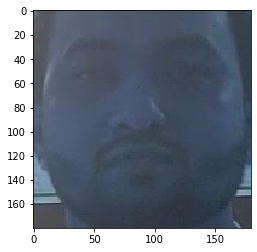

In [3]:
img=cv2.imread("E:/build_multi_face_recognizer/face_alignment/person2/person_2_700.jpg")
plt.imshow(img)
alpha=2
beta=40

#blur = cv2.blur(img, (5, 5))
def img_estim(img,thrshld):
    
    is_light = np.mean(img) > thrshld
    if is_light:  # The range for a pixel's value in grayscale is (0-255), 127 lies midway
        result_img=img # (127 - 255) denotes light image
        return result_img
    else:
        result_img=cv2.addWeighted(img,alpha,np.zeros(img.shape,img.dtype),0,beta) #g(x)=f(x)*alpha+beta
        return result_img

final_img=img_estim(img,127)  
 

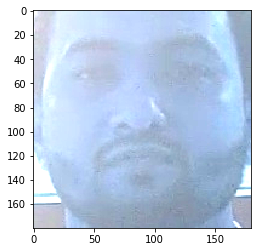

In [4]:
plt.imshow(final_img)

In [5]:
#...................face alignment......................

LEFT_EYE_INDICES = [36, 37, 38, 39, 40, 41]
RIGHT_EYE_INDICES = [42, 43, 44, 45, 46, 47]
def rect_to_tuple(rect):
    left = rect.left()
    right = rect.right()
    top = rect.top()
    bottom = rect.bottom()
    return left, top, right, bottom

def extract_eye(shape, eye_indices):
    points = map(lambda i: shape.part(i), eye_indices)
    return list(points)

def extract_eye_center(shape, eye_indices):
    points = extract_eye(shape, eye_indices)
    xs = map(lambda p: p.x, points)
    ys = map(lambda p: p.y, points)
    return sum(xs) // 6, sum(ys) // 6

def extract_left_eye_center(shape):
    return extract_eye_center(shape, LEFT_EYE_INDICES)

def extract_right_eye_center(shape):
    return extract_eye_center(shape, RIGHT_EYE_INDICES)

def angle_between_2_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    tan = (y2 - y1) / (x2 - x1)
    return np.degrees(np.arctan(tan))

def get_rotation_matrix(p1, p2):
    angle = angle_between_2_points(p1, p2)
    x1, y1 = p1
    x2, y2 = p2
    xc = (x1 + x2) // 2
    yc = (y1 + y2) // 2
    M = cv2.getRotationMatrix2D((xc, yc), angle, 1)
    return M


In [6]:
#detect what if face is dark or white from multiple images

def extract_face(frame,face):
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    face_frame = frame[y: y + h, x: x + w].copy()
    return face_frame

def face_alignment(image,faces):
    #plt.imshow(image)
    face = faces[0]
    #print(faces[0])
    shapes = predictor(image, face)
    left_eye = extract_left_eye_center(shapes)
    right_eye = extract_right_eye_center(shapes)
    
    # eye center
    eye_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
    
    height, width = image.shape[0], image.shape[1]
    #M = cv2.getRotationMatrix2D(eye_center, angle, 1)
    M=get_rotation_matrix(left_eye,right_eye)
    #print(image)
    image=cv2.warpAffine(image, M, (width,height))
    #plt.imshow(image)
    return image

video="E:/build_multi_face_recognizer/person_9/person_9.mp4"
save_img="E:/build_multi_face_recognizer/face_validator/"
capture = cv2.VideoCapture(video)
#print(capture)
frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
#print(frames_num)
images=[]
t=[]
for i in range(frames_num):
    capture.grab()
    if i % 50!= 0:
        continue
    success, frame = capture.retrieve()
    #print(frame) 
    if not success:
        continue
    id = os.path.splitext(os.path.basename(video))[0]
         
    #remove noise from frame_image
    #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
    image_copy = np.copy(frame)
        
    #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces=detector(frame)
    if len(faces)>0:
        #skew correction of images
        frame_1=face_alignment(image_copy,faces)
        for face in faces:
            # extrct only faces from frame
            frame_2=extract_face(frame_1,face)
            #check what if face is dark or white from images
            final_img=img_estim(frame_2,127)  
            save_img="E:/build_multi_face_recognizer/face_brightness_chekh/"
            cv2.imwrite(os.path.join(save_img,"{}_{}.jpg".format(id, i)),final_img)